## _Track Performance_

Note: We can't find Purity/Fake Rate and Duplication Rate from the _`particles.h5`_ with current variables we have.

In [1]:
import glob, os, sys, yaml

In [2]:
import math, time
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torch
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial

In [5]:
sys.path.append('..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### _Read Particles HDF5 Store_

- To consistent with resutls, we chose $MF > 50\%$, Minimum True Hits $\ge 7$ STT hits for reconstructable particles, and Minimum Reco Hits $\ge 5, 6$ for reconstucted tracks.

In [6]:
# MF >50%, Functor: >= 7 STT hits, and Min Reco. Hits 5 STT hits
path = "/home/nikin105/mlProject/data/machineLearning/mum5mup5/evaluation/mum5mup5/layerwise_100k/0.5_particles.h5"

In [7]:
# load HDFStore
store = pd.HDFStore(path)

In [8]:
# store.get('data').head()
df = store['data']

In [22]:
df

,particle_id,pt,vx,vy,vz,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,9,0.888198,0.0,0.0,0.0,-13,0.724459,0.970350,0.783487,17.0,True,True,1001
1,8,0.409969,0.0,0.0,0.0,-13,2.358487,-0.884619,0.379028,15.0,True,True,1001
2,7,0.330104,0.0,0.0,0.0,-13,1.601406,-0.030614,-2.555190,17.0,True,True,1001
3,6,0.119895,0.0,0.0,0.0,-13,0.805353,0.853429,2.043232,68.0,True,True,1001
4,5,1.078180,0.0,0.0,0.0,-13,0.823418,0.828590,0.957641,18.0,True,True,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,4,0.954271,0.0,0.0,0.0,13,1.875093,-0.309104,1.850946,17.0,True,True,99994
6,3,0.630116,0.0,0.0,0.0,13,0.613844,1.149053,-2.588689,14.0,True,True,99994
7,2,0.468583,0.0,0.0,0.0,13,2.342213,-0.861737,2.712100,16.0,True,True,99994
8,1,0.608244,0.0,0.0,0.0,13,2.422785,-0.978905,-1.792101,11.0,True,True,99994


In [38]:
out_prefix = "mum5mup5"
image_dir = "/home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/mum5mup5/layerwise_100k/evaluation/"

In [39]:
pt = df.pt.values
vx = df.vx.values
vy = df.vy.values
d0 = np.sqrt(vx**2 + vy**2)
z0 = df.vz.values

#charge = df.q
pdgcode = df.pdgcode

peta = df.peta.values
ptheta = (df.ptheta.values*180)/np.pi   # radians to degrees
pphi = (df.pphi.values*180)/np.pi       # radians to degrees

pt_matched = df.query("is_matched").pt.values
pt_trackable = df.query("is_trackable").pt.values
pt_matched_trackable = df.query("is_matched and is_trackable").pt.values

matched_idx = df.is_matched             # matched
rectable_idx = df.is_trackable          # reconstructable

In [40]:
sns.set_theme(style="whitegrid", context="talk")
sns.set_color_codes()

/home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/mum5mup5/layerwise_100k/evaluation/mum5mup5_pt.pdf


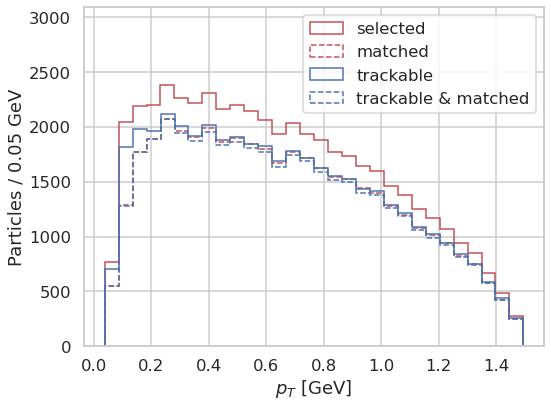

In [43]:
plt.close("all")
bin_width = 0.02
figure, ax = plt.subplots(figsize=(8, 6))

n, bins, patches = plt.hist(pt, 30, histtype="step", color="r", ls="-", label="selected")
n2, bins2, patches2 = ax.hist(pt_matched, 30, histtype="step", color="r", ls="--", label="matched")
n3, bins3, patches3 = ax.hist(pt_trackable, 30, histtype="step", color="b", ls="-", label="trackable")
n4, bins4, patches4 = ax.hist(
    pt_matched_trackable, 30, histtype="step", color="b", ls="--", label="trackable & matched"
)
bw = bins[1] - bins[0]
ax.set_xlabel("$p_T$ [GeV]")
ax.set_ylabel(f"Particles / {bw:.2f} GeV")
ax.set_ylim(0, 1.3 * max(n))
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(image_dir, f"{out_prefix}_pt.png"), dpi=300)
plt.savefig(os.path.join(image_dir, f"{out_prefix}_pt.pdf"), dpi=300)
print(os.path.join(image_dir, f"{out_prefix}_pt.pdf"))

In [47]:
fx = (bins[:-1] + bins[1:])/2

f = np.zeros(len(n))
ferr = np.zeros(len(n))
f2 = np.zeros(len(n))
f2err = np.zeros(len(n))

for i in range(len(n)):
    if n[i] == 0 or n2[i] == 0 or n3[i] == 0 or n4[i] == 0:
        f[i] = 0
        f2[i] = 0
        ferr[i] = 0
        f2err[i] = 0
    else:
        f[i] = n2[i]/n[i] * 100
        ferr[i] = np.sqrt(n2[i]/n[i]**2 + n2[i]**2/n[i]**3) * 100
        f2[i] = n4[i]/n3[i] * 100
        f2err[i] = np.sqrt(n4[i]/n3[i]**2 + n4[i]**2/n3[i]**3) * 100
avf2 = np.average(f2)
print(f"average efficiency: {avf2:.2f}")

average efficiency: 95.72


/home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/mum5mup5/layerwise_100k/evaluation/mum5mup5_efficiency.pdf


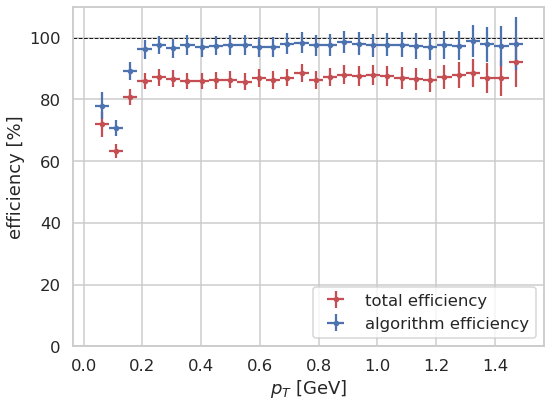

In [58]:
figure, ax = plt.subplots(figsize=(8, 6))

ax.axhline(100, color='k', ls='--', lw=1)
ax.errorbar(fx, f, yerr=ferr, xerr=bw/2, fmt='.', label='total efficiency', color="r")
ax.errorbar(fx, f2, yerr=f2err, xerr=bw/2, fmt='.', label='algorithm efficiency', color="b")
ax.set_xlabel('$p_T$ [GeV]')
ax.set_ylabel('efficiency [%]')
ax.set_ylim(0, 110)
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(image_dir, f"{out_prefix}_efficiency.png"), dpi=300)
plt.savefig(os.path.join(image_dir, f"{out_prefix}_efficiency.pdf"), dpi=300)
print(os.path.join(image_dir, f"{out_prefix}_efficiency.pdf"))

### _1. Tranverse Momentum_

In [ ]:
pt_min, pt_max = min(pt), max(pt)

# linear scale on x-axis
pt_bins = np.linspace(pt_min, pt_max, num=50)

# log scale on x-axis
# pt_bins = np.logspace(np.log10(pt_min), np.log10(pt_max), 20)

# pt_bins = [0, 0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3] #, 0.35, 0.6]

pt_configs = {
    'bins': pt_bins,
    'histtype': 'step',
    'lw': 1,
    'log': False
}

In [ ]:
# vertex cuts
all_cuts = [0]

for (cut_pt) in all_cuts:
    print("cut_pt: {}".format(cut_pt))

    cuts = (pt > cut_pt)

    # make pt plots
    sel_particles = pt[cuts]                                        # selected/generated
    sel_matched_particles = pt[cuts & matched_idx]                  # selected and matched
    reco_particles = pt[cuts & rectable_idx]                        # selected and reconstructable
    reco_matched_particles = pt[cuts & rectable_idx & matched_idx]  # selected, reconstructable and matched
    
    # print("efficiency (phys.): ", (sel_matched_particles.shape[0]/sel_particles.shape[0]*100))
    # print("efficiency (tech.): ", (reco_matched_particles.shape[0]/reco_particles.shape[0]*100))
    
    make_cmp_plot_fn([sel_particles, sel_matched_particles, reco_particles, reco_matched_particles], 
        configs=pt_configs, xlabel=r"$p_t$ [GeV]",
        outname=os.path.join(outdir, "{}_pt_cut{}".format(out_prefix, cut_pt)),
        ymin=0.0, loc='upper right')
    
plt.axhline(y=1, color='r', linestyle='--')

### _2. Theta Angle_

In [ ]:
min(ptheta), max(ptheta)

In [ ]:
ptheta_min, ptheta_max = min(ptheta), max(ptheta)

# ptheta_min, ptheta_max = 20,140

# linear scale on x-axis
ptheta_bins = np.linspace(22, ptheta_max, num=20)

# log scale on x-axis
# ptheta_bins = np.logspace(np.log10(ptheta_min), np.log10(ptheta_max), 20)

# ptheta_bins = [22, 28, 34, 40, 46, 52, 58, 64, 74, 84, 92, 105, 120, 142]

ptheta_configs = {
    'bins': ptheta_bins,
    'histtype': 'step',
    'lw': 1,
    'log': False
}

In [ ]:
# vertex cuts
all_cuts = [0.0]

for (cut_ptheta) in all_cuts:
    print("cut_ptheta: {}".format(cut_ptheta))

    cuts = (ptheta > cut_ptheta)

    # make pt plots
    sel_particles = ptheta[cuts]                                        # selected/generated
    sel_matched_particles = ptheta[cuts & matched_idx]                  # selected and matched
    reco_particles = ptheta[cuts & rectable_idx]                        # selected and reconstructable
    reco_matched_particles = ptheta[cuts & rectable_idx & matched_idx]  # selected, reconstructable and matched
    
    # print("efficiency (phys.): ", (sel_matched_particles.shape[0]/sel_particles.shape[0]*100))
    # print("efficiency (tech.): ", (reco_matched_particles.shape[0]/reco_particles.shape[0]*100))
    
    make_cmp_plot_fn([sel_particles, sel_matched_particles, reco_particles, reco_matched_particles], 
        configs=ptheta_configs, xlabel=r"$\theta$ [Deg.]",
        outname=os.path.join(outdir, "{}_ptheta_cut{}".format(out_prefix, cut_ptheta)),
        ymin=0.0, loc='upper right')

### _3. Phi Angle_

In [ ]:
min(pphi), max(pphi)

In [ ]:
pphi_min, pphi_max = min(pphi), max(pphi)

# linear scale on x-axis
pphi_bins = np.linspace(-180, 180, num=15)

pphi_configs = {
    'bins': pphi_bins,
    'histtype': 'step',
    'lw': 1,
    'log': False
}

In [ ]:
# vertex cuts
all_cuts = [-180]

for (cut_pphi) in all_cuts:
    print("cut_pphi: {}".format(cut_pphi))

    cuts = (pphi > cut_pphi)

    # make pt plots
    sel_particles = pphi[cuts]                                        # selected/generated
    sel_matched_particles = pphi[cuts & matched_idx]                  # selected and matched
    reco_particles = pphi[cuts & rectable_idx]                        # selected and reconstructable
    reco_matched_particles = pphi[cuts & rectable_idx & matched_idx]  # selected, reconstructable and matched
    
    # print("efficiency (phys.): ", (sel_matched_particles.shape[0]/sel_particles.shape[0]*100))
    # print("efficiency (tech.): ", (reco_matched_particles.shape[0]/reco_particles.shape[0]*100))
    
    make_cmp_plot_fn([sel_particles, sel_matched_particles, reco_particles, reco_matched_particles], 
        configs=pphi_configs, xlabel=r"$\phi$ [Deg.]",
        outname=os.path.join(outdir, "{}_pphi_cut{}".format(out_prefix, cut_pphi)),
        ymin=0.0, loc='lower center')

### _4. Decay Vertex_

In [ ]:
min(d0), max(d0)

In [ ]:
d0_min, d0_max = min(d0), max(d0)

# linear scale on x-axis
d0_bins = np.linspace(d0_min, 15, num=15)   # will give 15 bins

# log scale on x-axis
# ptheta_bins = np.logspace(np.log10(ptheta_min), np.log10(ptheta_max), 20)

# d0_bins = [0., 1.1, 2.15, 3.2, 4.0, 5.3, 6.5, 7.5, 8.5, 9.5, 10.7, 12, 15]

d0_configs = {
    'bins': d0_bins,
    'histtype': 'step',
    'lw': 1,
    'log': False
}

In [ ]:
# vertex cuts
all_cuts = [0.0]

for (cut_d0) in all_cuts:
    print("cut_d0: {}".format(cut_d0))

    cuts = (d0 > cut_d0)

    # make pt plots
    sel_particles = d0[cuts]                                        # selected/generated
    sel_matched_particles = d0[cuts & matched_idx]                  # selected and matched
    reco_particles = d0[cuts & rectable_idx]                        # selected and reconstructable
    reco_matched_particles = d0[cuts & rectable_idx & matched_idx]  # selected, reconstructable and matched
    
    # print("efficiency (phys.): ", (sel_matched_particles.shape[0]/sel_particles.shape[0]*100))
    # print("efficiency (tech.): ", (reco_matched_particles.shape[0]/reco_particles.shape[0]*100))
    
    make_cmp_plot_fn([sel_particles, sel_matched_particles, reco_particles, reco_matched_particles], 
        configs=d0_configs, xlabel=r"$d_0$ [cm]",
        outname=os.path.join(outdir, "{}_d0_cut{}".format(out_prefix, cut_d0)),
        ymin=0.0, loc='upper right')

___
## _Recreate the Summary from Track Evalution Script_

In [ ]:
df.head()

In [ ]:
# Lets find Phys. and Tech. Efficicencies
sel_particles = df                                        # selected/generated
sel_matched_particles = df[matched_idx]                   # selected and matched
reco_particles = df[rectable_idx]                         # selected and reconstructable
reco_matched_particles = df[rectable_idx & matched_idx]   # selected, reconstructable and matched

In [ ]:
sel_particles.shape[0], sel_matched_particles.shape[0], reco_particles.shape[0], reco_matched_particles.shape[0]

- _Physics Efficiency_

In [ ]:
# Physics Efficiency = (sel, matched)/sel
print("efficiency (phys.): {:>3.2f}%".format(sel_matched_particles.shape[0]/sel_particles.shape[0]*100))

In [ ]:
n_sel_particles = df.shape[0]
n_matched_sel_particles = df[df.is_matched].shape[0]
print("Tracking Efficiency (Phys.): {:>3.2f}%".format(100 * n_matched_sel_particles/n_sel_particles))

- _Technical Efficiency_

In [ ]:
# Technical Efficiency = (sel, reconstructable, matched)/(sel, reconstructable)
print("efficiency (tech.): {:>3.2f}%".format(reco_matched_particles.shape[0]/reco_particles.shape[0]*100))

## _Efficiency Difference Between Positive and Negative Charge_

- Lets plot difference of overall tracking efficiences for positive and negative charges.

In [ ]:
# fiducial cut on charge
fiducial_pos = (charge > 0)
fiducial_neg = (charge < 0)

In [ ]:
def sel_particles(var, fiducial):
    sel_particles = var[fiducial]                                        # selected/generated
    sel_matched_particles = var[fiducial & matched_idx]                  # selected and matched
    return sel_particles, sel_matched_particles

In [ ]:
def reco_particles(var, fiducial):
    reco_particles = var[fiducial & rectable_idx]                        # selected and reconstructable
    reco_matched_particles = var[fiducial & rectable_idx & matched_idx]  # selected, reconstructable and matched
    return reco_particles, reco_matched_particles

- Difference in overall efficiency

In [ ]:
pt = df.pt

In [ ]:
sel, sel_matched = sel_particles(pt, fiducial_pos)

sel_vals, sel_bins = np.histogram(sel, bins=pt_bins)
sel_match_vals, sel_match_bins = np.histogram(sel_matched, bins=pt_bins)

eff1, err1 = get_ratio(sel_match_vals, sel_vals)
xvals1 = (sel_bins[1:] + sel_bins[:-1]) / 2
xerrs1 = (sel_bins[1:] - sel_bins[:-1]) / 2

In [ ]:
sel, sel_matched = sel_particles(pt, fiducial_neg)

sel_vals, sel_bins = np.histogram(sel, bins=pt_bins)
sel_match_vals, sel_match_bins = np.histogram(sel_matched, bins=pt_bins)

eff2, err2 = get_ratio(sel_match_vals, sel_vals)
xvals2 = (sel_bins[1:] + sel_bins[:-1]) / 2
xerrs2 = (sel_bins[1:] - sel_bins[:-1]) / 2

In [ ]:
xvals = [e1 - e2 for (e1, e2) in zip(xvals1, xvals2)]
xerrs = [e1 - e2 for (e1, e2) in zip(xerrs1, xerrs2)]
eff = [e1 - e2 for (e1, e2) in zip(eff1, eff2)]
err = [math.sqrt(e1**2 + e2**2) for (e1, e2) in zip(err1, err2)]

In [ ]:
# Plot the ratio of the histograms as an efficiency
fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(xvals1, eff, xerr=xerrs1, yerr=err, fmt='o', color='b', label='Phys. Efficiency (Difference)')
ax.axhline(y = 0., color = 'r', linestyle = '-')

# Add x and y labels
ax.set_xlabel('$p_t \: [GeV]$', fontsize=20)
ax.set_ylabel('Efficiency Difference', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
# ax.set_xlim(0, 0.6)
ax.set_ylim(-0.15, 0.15)
# ax.legend(fontsize=20, loc='best')
ax.grid(False)
fig.tight_layout()
plt.show()

### _Plotting Efficiency_

In [ ]:
def plot_observable_performance(particles: pd.DataFrame):

    pt = particles.pt.values
    eta = particles.peta.values
    
    matched_idx = particles.is_matched
    rectable_idx = particles.is_trackable
    

    # plot the performance `metric` as a function of `observable`    
    make_cmp_plot_fn = partial(make_cmp_plot,
        legends=["Selected", "Sel. Matched", "Reconstructable", "Reconst. Matched"],
        ylabel="Num. particles", ratio_label='Track efficiency',
        ratio_legends=["Physics Eff", "Technical Eff"])

    all_cuts = [(0, 4)]
    for (cut_pt, cut_eta) in all_cuts:
        cuts = (pt > cut_pt) & (np.abs(eta) < cut_eta)
        
        # make pt plots
        sel_particles = pt[cuts]                                        # selected/generated
        sel_matched_particles = pt[cuts & matched_idx]                  # selected and matched
        reco_particles = pt[cuts & rectable_idx]                        # selected and reconstructable
        reco_matched_particles = pt[cuts & rectable_idx & matched_idx]  # selected, reconstructable and matched


        print("efficiency (phys.): ", (sel_matched_particles.shape[0]/sel_particles.shape[0]*100))
        print("efficiency (tech.): ", (reco_matched_particles.shape[0]/reco_particles.shape[0]*100))

        make_cmp_plot_fn([sel_particles, sel_matched_particles, reco_particles, reco_matched_particles],
                         configs=pt_configs, xlabel="pT [MeV]",
                         outname=os.path.join(outdir, "test_pt_cut{}".format(cut_pt)),
                         ymin=0.6)


In [ ]:
# plot_observable_performance(df)

In [ ]:
def plot_pt_eff(particles):
    """Phys Eff: pt vs reco_pt, Tech Eff: true_pt vs reco_pt"""
    
    pt = particles.pt.values
    gen_pt = pt
    true_pt = pt[particles["is_trackable"]]
    reco_pt = pt[particles["is_trackable"] & particles["is_matched"]]

    # Get histogram values of true_pt and reco_pt
    gen_vals, gen_bins = np.histogram(gen_pt, bins=pt_bins)
    true_vals, true_bins = np.histogram(true_pt, bins=pt_bins)    # change gen_pt, true_pt to get phys/tech eff.
    reco_vals, reco_bins = np.histogram(reco_pt, bins=pt_bins)

    # Plot the ratio of the histograms as an efficiency
    fig, ax = plt.subplots(figsize=(8,6))
    
    eff, err = get_ratio(reco_vals, gen_vals)
    xvals = (true_bins[1:] + true_bins[:-1]) / 2
    xerrs = (true_bins[1:] - true_bins[:-1]) / 2
    
    ax.errorbar(xvals, eff, xerr=xerrs, yerr=err, fmt='o', label='Phys. Efficiency')
    
    eff, err = get_ratio(reco_vals, true_vals)
    xvals = (true_bins[1:] + true_bins[:-1]) / 2
    xerrs = (true_bins[1:] - true_bins[:-1]) / 2
    
    ax.errorbar(xvals, eff, xerr=xerrs, yerr=err, fmt='o', label='Tech. Efficiency')    
    
    # Add x and y labels
    ax.set_xlabel('$p_t [GeV]$', fontsize=20)
    ax.set_ylabel('Track Efficiency', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    # ax.set_xlim(0, 0.6)
    # ax.set_ylim(0, 1.5)
    # ax.legend(fontsize=20, loc='best')
    ax.grid(False)
    fig.tight_layout()
    # fig.savefig("test_eff.pdf")

In [ ]:
# plot_pt_eff(df)

In [ ]:
def plot_particles(particles):
    """Phys Eff: pt vs reco_pt, Tech Eff: true_pt vs reco_pt"""
    
    pt = particles.pt.values
    gen_pt = pphi
    true_pt = ppi[particles["is_trackable"]]
    reco_pt = pt[particles["is_trackable"] & particles["is_matched"]]

    # Get histogram values of true_pt and reco_pt
    gen_vals, gen_bins = np.histogram(gen_pt, bins=pt_bins)
    true_vals, true_bins = np.histogram(true_pt, bins=pt_bins)    # change gen_pt, true_pt to get phys/tech eff.
    reco_vals, reco_bins = np.histogram(reco_pt, bins=pt_bins)

    # Plot the ratio of the histograms as an efficiency
    fig, ax = plt.subplots(figsize=(8,6))
    
    legend=["Selected", "Reconstructable", "Reconst. Matched"]
    
    vals, bins, _ = ax.hist(gen_pt, pt_bins, label=legend[0])
    vals, bins, _ = ax.hist(true_pt, pt_bins, label=legend[1])
    vals, bins, _ = ax.hist(reco_pt, pt_bins, label=legend[2])

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    
    add_up_xaxis(ax)
    ax.legend(loc='upper right', fontsize=16)
    ax.grid(False)
    fig.savefig("{}.pdf".format(outname))
    
    # Add x and y labels
    ax.set_xlabel('$p_t [GeV]$', fontsize=20)
    ax.set_ylabel('Particles', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    # ax.set_xlim(0, 0.6)
    # ax.set_ylim(0, 1.5)
    # ax.legend(fontsize=20, loc='best')
    ax.grid(False)
    fig.tight_layout()
    # fig.savefig("test_particles.pdf")

In [ ]:
# plot_particles(df)

In [ ]:
# fig, ax = plt.subplots(figsize=(8,6))
# ax.hist(pphi)

In [ ]:
store.close()